# Export to GDS file

[GDS](https://en.wikipedia.org/wiki/GDSII) is a binary file format used to represent planar geometric shapes, text labels, and other information about integrated circuits layout in hierarchical form. The GDS file generation is usually the last step in the photonic design workflow.

<img src="img/export_to_gds.png" alt="GDS layout image" width="400"/>

Tidy3D [geometries](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/index.html#geometry), [structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html#tidy3d.Structure), and [simulations](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation) can be exported to GDS format via the third-party [gdstk](https://heitzmann.github.io/gdstk/) or [gdspy](https://gdspy.readthedocs.io/en/stable/) packages.

There are 4 methods available on those objects to export them to GDS. All of them take an axis coordinate (either `x`, `y`, or `z`) that defines the cross-section plane from which to export the GDS polygons. Geometry and structure methods also take the `layer` and `datatype` numbers to export, whereas simulations require defining a dictionary maping structure media to `layer` and `datatype`. This dictionary allows us to export each medium to a separate GDS layer/datatype. Structure and simulation methods also accept a `permittivity_threshold` and `frequency` arguments, which can be used to sample custom medium when exporting geometry, for example, from an inverse designed structure.

- [`Geometry.to_gds_file`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Geometry.html#tidy3d.Geometry.to_gds_file), [`Structure.to_gds_file`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html#tidy3d.Structure.to_gds_file), [`Simulation.to_gds_file`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file): export the cross-section polygons directly to a GDS file.

- [`Geometry.to_gds`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Geometry.html#tidy3d.Geometry.to_gds), [`Structure.to_gds`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html#tidy3d.Structure.to_gds), [`Simulation.to_gds`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds): append the cross-section polygons to a pre-existing `gdstk.Cell` or `gdspy.Cell`.

- [`Geometry.to_gdstk`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Geometry.html#tidy3d.Geometry.to_gdstk), [`Structure.to_gdstk`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html#tidy3d.Structure.to_gdstk), [`Simulation.to_gdstk`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gdstk): returns a list with cross-section polygons as `gdstk.Polygon`.

- [`Geometry.to_gdspy`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Geometry.html#tidy3d.Geometry.to_gdspy), [`Structure.to_gdspy`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html#tidy3d.Structure.to_gdspy), [`Simulation.to_gdspy`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gdspy): returns a list with cross-section polygons as `gdspy.Polygon` and `gdspy.PolygonSet`.

In this notebook, we show a few examples of using these functions to create GDS polygons, cells and files from `Tidy3D`.
To import existing GDS files into Tidy3D simulations refer to the [Importing GDS files](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/GDSImport.html) tutorial. If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdstk
import os

# tidy3d import
import tidy3d as td
from tidy3d import web

Here we have some parameters used throughout the notebook.

In [2]:
# Wavelengths
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

## Example 1: Waveguide and Ring
We will start by defining a simulation including two waveguides, a ring, and a custom medium structure. We will employ different mediums to illustrate how to organize them in multiple layers.

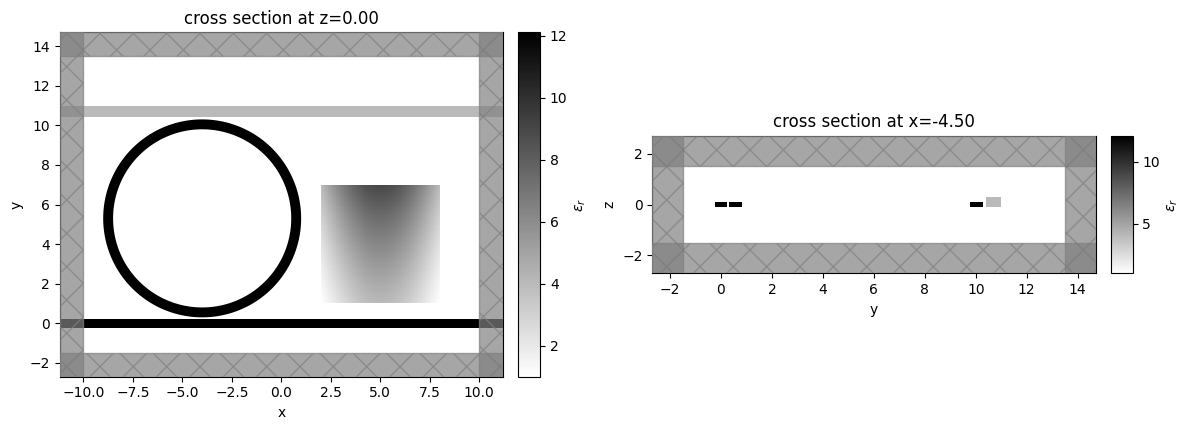

In [3]:
core_medium = td.Medium(permittivity=3.48 ** 2)
wg = td.Structure(geometry=td.Box(size=(30, 0.45, 0.22)), medium=core_medium)

ring_geo = (
    td.Cylinder(radius=5, length=0.22, axis=2, center=(-4, 5.3, 0))
    - td.Cylinder(radius=4.5, length=0.22, axis=2, center=(-4, 5.3, 0))
)
ring = td.Structure(geometry=ring_geo, medium=core_medium)

alternative_medium = td.Medium(permittivity=2.0 ** 2)
wg2 = td.Structure(
    geometry=td.Box(center=(0, 10.7, 0.2 - 0.11), size=(30, 0.6, 0.4)),
    medium=alternative_medium,
)

# Structure defined by a custom medium
x = np.linspace(2, 8, 121)
y = np.linspace(1, 7, 121)
z = [0]
x_mesh, y_mesh, z_mesh = np.meshgrid(x, y, z, indexing="ij")

n = 2.0 + (y_mesh - 1) / 6 - ((x_mesh - 5) / 3) ** 2
n_dataset = td.SpatialDataArray(n, coords=dict(x=x, y=y, z=z))

custom_medium = td.CustomMedium.from_nk(n_dataset, interp_method="nearest")
custom_structure = td.Structure(
    geometry=td.Box(center=(5, 4, 0), size=(6, 6, 0.22)),
    medium=custom_medium,
)

sim = td.Simulation(
    center=(0, 6, 0),
    size=(20, 15, 3),
    structures=[wg, ring, wg2, custom_structure],
    grid_spec=td.GridSpec.uniform(0.1),
    run_time=1e-12,
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

_ = sim.plot_eps(z=0, ax=ax[0])
_ = sim.plot_eps(x=-4.5, ax=ax[1])

We can start by exporting single geometries using `.to_gds_file`:

In [4]:
ring_geo.to_gds_file("./misc/gds_export_ring.gds", z=0, gds_layer=1, gds_dtype=2, gds_cell_name="RING")

Then, we can look at the resulting GDS file in any compatible viewer. Here's the result in [KLayout](https://www.klayout.de/):

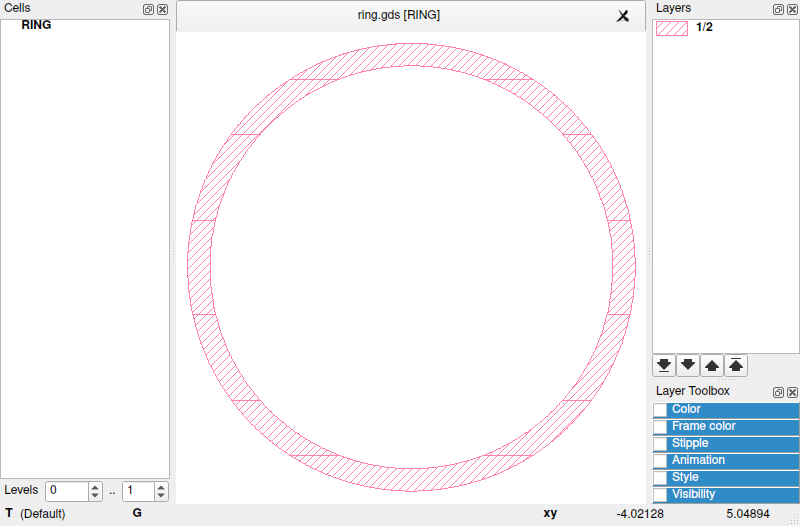

Structures can be exported in a similar way, but in order to handle custom medium, we can specify the permittivity threshold that defined the polygon's boundaries. That functionality is not available via `gdspy`, only through `gdstk`. We will use the `to_gdstk` method instead of storing them directly to a file this time.

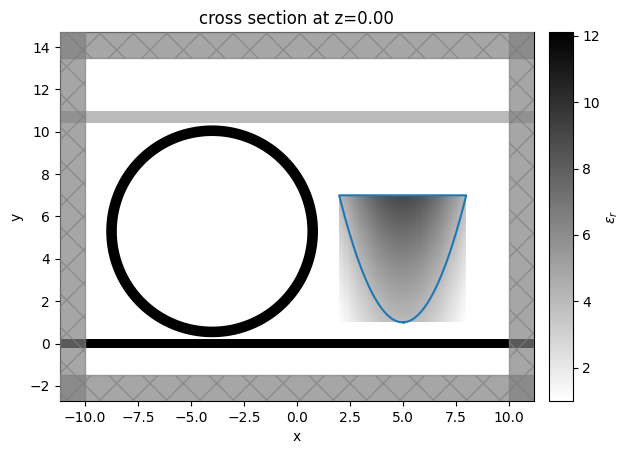

In [5]:
polygons = custom_structure.to_gdstk(z=0, permittivity_threshold=2.0**2, frequency=freq0)

# We can plot the retrieved polygons on top of our simulation to see how they match
ax = sim.plot_eps(z=0)
for polygon in polygons:
    vertices = polygon.points
    vertices = np.vstack((vertices, vertices[0]))
    ax.plot(vertices[:,0], vertices[:, 1])

Now, we will export the geometry directly to a `gdstk.Cell`. This way, it is possible, for example, to append geometries from multiple `z` levels or with different thresholds.

In [6]:
cell = gdstk.Cell("MAIN")

layer_map = {
    core_medium: (1, 2),
    alternative_medium: (2, 2),
    custom_medium: (3, 3),
}
sim.to_gds(
    cell, z=0, permittivity_threshold=2.0**2, frequency=freq0, gds_layer_dtype_map=layer_map
)

print(cell)

Cell 'MAIN' with 4 polygons, 0 flexpaths, 0 robustpaths, 0 references, and 0 labels


Let's add another level of the custom medium to the same cell and save the file.

In [7]:
custom_structure.to_gds(
    cell,
    z=0,
    permittivity_threshold=2.5**2,
    frequency=freq0,
    gds_layer=3,
    gds_dtype=4,
)

lib = gdstk.Library()
lib.add(cell)
lib.write_gds("./misc/gds_export_ring_bus.gds")

Once more, we will take a loot at the result in Klayout.

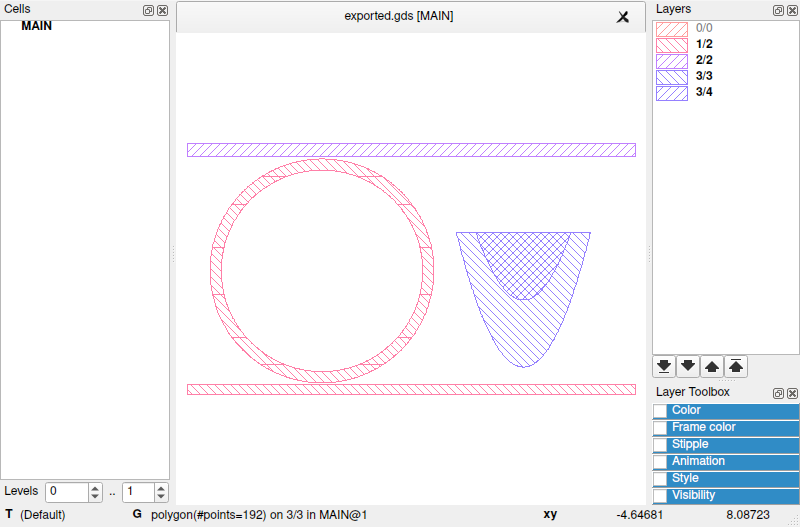

## Example 2: Directional Coupler

In this example, we will create a directional coupler (DC) simulation and export it to GDS. To define the DC geometry we will use a function presented in the [Defining common integrated photonic components](https://www.flexcompute.com/tidy3d/examples/notebooks/PICComponents/) tutorial.

In [8]:
# Directional coupler function.
def directional_coupler(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    wg_spacing_in,
    wg_spacing_coup,
    wg_length,
    coup_length,
    bend_length,
    medium,
    sidewall_angle=0,
):

    """
    This function defines a directional coupler and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of directional coupler center (um)
    y0: y coordinate of directional coupler center (um)
    z0: z coordinate of directional coupler center (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    wg_spacing_in : spacing between the input straight waveguides (um)
    wg_spacing_coup: gap size of the coupling region (um)
    wg_length: length of the input straight waveguides (um)
    coup_length：length of the coupling region (um)
    bend_length: length of the bending (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("dc")  # define a gds cell

    # define a path
    coup = gdstk.RobustPath(
        (-wg_length - bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        wg_width,
        layer=1,
        datatype=0,
    )

    coup.segment((-bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    A = (wg_spacing_in - wg_spacing_coup - wg_width) / 4

    coup.segment(
        (-coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: A * np.cos(np.pi * u) - A,
    )

    coup.segment((coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    coup.segment(
        (bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: -A * np.cos(np.pi * u) - A,
    )
    coup.segment(
        (wg_length + bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0)
    )

    # add path to the cell
    cell.add(coup)

    # add the mirrored path to the cell
    cell.add(coup.copy().mirror((x0 + 1, y0), (x0, y0)))

    # define geometry from the gds cell
    dc_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    dc = td.Structure(geometry=td.GeometryGroup(geometries=dc_geo), medium=medium)

    return dc

The waveguides material is silicon and the surrounding medium is silica. We will also include metallic pads.

In [9]:
# Materials definition.
mat_si = td.Medium(permittivity=3.47**2)
mat_sio2 = td.Medium(permittivity=1.44**2)
mat_gold = td.material_library["Au"]["JohnsonChristy1972"]

Now, we will build the simulation including the DC structure, a mode source, and a field monitor. The DC structure is only for demonstration purposes, so it is not intended to be optimized. Two gold pads are included to illustrate the organization of different mediums in layers. 

In [10]:
# Create the DC structure.
dc = directional_coupler(
    x0=0,
    y0=0,
    z0=0,
    wg_spacing_in=10,
    wg_width=0.50,
    wg_thickness=0.22,
    wg_spacing_coup=0.1,
    coup_length=5,
    bend_length=6,
    wg_length=10,
    medium=mat_si,
    sidewall_angle=0,
)

# Two gold pads for illustration purpose.
sq_up = td.Structure(
    geometry=td.Box(center=(0, 3, 0), size=(4, 2, 0.22)),
    medium=mat_gold,
)

sq_dw = td.Structure(
    geometry=td.Box(center=(0, -3, 0), size=(4, 2, 0.22)),
    medium=mat_gold,
)

# Add a mode source as excitation.
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.47)
mode_source = td.ModeSource(
    center=(-10, 5, 0),
    size=(0, 2, 1.5),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Add a field monitor to visualize field distribution.
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# construct simulation
sim_ii = td.Simulation(
    center=(0, 0, 0),
    size=(21, 14, 2),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[dc, sq_up, sq_dw],
    sources=[mode_source],
    monitors=[field_monitor],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=mat_sio2,
)

Let's visualize the simulation and verify if all the components are in their correct places.

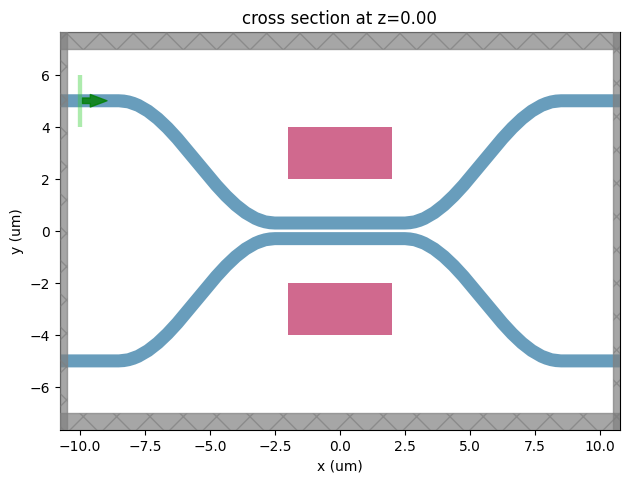

In [11]:
ax = sim_ii.plot(z=0.001)
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
plt.show()

For completeness, you can uncomment the lines below and run the simulation before exporting it to GDS. However, it is worth mentioning that it is not even necessary. Once you build the simulation object, you can create the GDS file from it.

In [12]:
# sim_data = web.run(
#    simulation=sim, task_name="dc_gds_export", path="data/simulation_data.hdf5"
# )

In [13]:
# sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
# plt.show()

We will use the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) function to export the `Simulation` object to a GDS file. In this case, we will set a `xy` plane through the `z = 0` coordinate and create a layer map to assign the `mat_si` medium to layer `(0, 0)` and `mat_gold` to layer `(1, 0)`.

In [14]:
layer_map_ii = {
    mat_si: (0, 0),
    mat_gold: (1, 0),
}

sim_ii.to_gds_file(
    fname="./misc/gds_export_dc.gds",
    z=0,
    gds_cell_name="DC",
    gds_layer_dtype_map=layer_map_ii,
)

Finaly, let's see the generated GDS in Klayout.

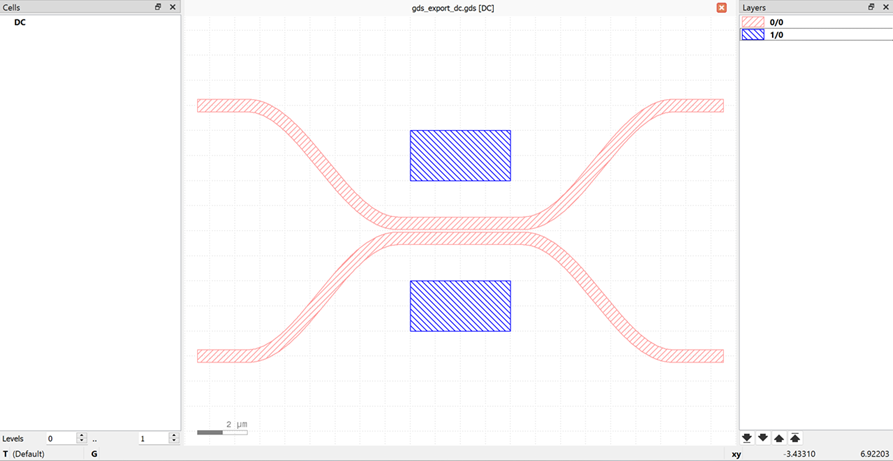